## Some imports

In [1]:
from google.colab import drive

!pip install rdkit-pypi
!pip install py3Dmol
drive.mount('/content/drive')

     |████████████████████████████████| 22.5 MB 1.2 MB/s 
Mounted at /content/drive


In [11]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import BatchNormalization
from keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

## Data preprocessing
Dataset contains drug-like compounds which can be potential inhibitors of GP120 - CD4 interaction. Compounds are stored in SMILES format. Also data contains binding free energy for molecules.

In [3]:
DATASETS_FOLDER = '/content/drive/MyDrive/datasets/gp120'

smifile = f'{DATASETS_FOLDER}/gp120_cleaned.csv'
data = pd.read_csv(smifile, header=0)
del data['babel_smiles'], data['filepath_smi']
data.head()

,energy,smiles
0,-8.1,Cc1ccc(C(=O)CN2NN=C(C3CC3)[C@@H]2c2ccccc2F)cc1
1,-8.0,CCOC1=CC(=O)[C@@H](CC2=NNN(CC(=O)c3ccc(C)cc3)[...
2,-7.7,Cc1ccc(C(=O)CN2NN=C(CNC(C)(C)CO)[C@H]2C(C)(C)C...
3,-7.1,Cc1ccc(OC[C@H]2C(CN3CCOCC3)=NNN2CC(=O)c2ccc(C)...
4,-6.8,Cc1ccc(C(=O)CN2NN=C(CCO)[C@@H]2C2(O)CC2)cc1


### Train and test sets creation
First of all, we need to shuffle our data and divide it into train and test datasets.

In [4]:
data = data.sample(frac=1, random_state=42)

smiles_train, smiles_test = train_test_split(data.drop('energy', axis=1), test_size=0.05, shuffle=False)
energy_train, energy_test = train_test_split(data.drop('smiles', axis=1), test_size=0.05, shuffle=False)
print(smiles_train.shape)
print(smiles_test.shape)

(67842, 1)
(3571, 1)


### SMILES alphabet
The autoencoder input layer receives a tensor of numbers and works with it. So we need to vectorize SMILES representation of molecules. This can be done with one-hot encoding. To create binary vector which represents SMILES, we need to count number of distinct symbols in compound formulas and the max length of word in dataset first. We also add "!" and "E" symbols to alphabet as start and end symbols.

In [5]:
charset = set("".join(list(data.smiles)) + "!E")
char_to_int = dict((c, i) for i, c in enumerate(charset))
int_to_char = dict((i, c) for i, c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5

print(f'alphabet size: {len(charset)}')
print(f'max smiles len: {embed}')

alphabet size: 32
max smiles len: 95


### SMILES length distribution

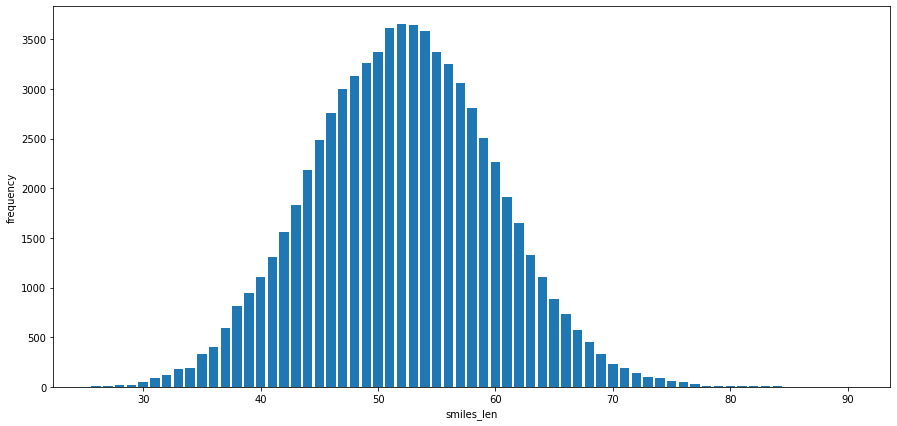

In [6]:
data['smiles_len'] = np.array([len(smiles) for smiles in data.smiles])
frequencies = data.smiles_len.value_counts()

plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(frequencies.index, frequencies)
plt.xlabel('smiles_len')
plt.ylabel('frequency')
plt.show()

### Distribution of chars frequencies

In [7]:
from copy import deepcopy

def count_char_freq(char):
    return sum([smile.count(char) for smile in data.smiles])

tmp_char_set = deepcopy(charset)
tmp_char_set.remove('!')
tmp_char_set.remove('E')
tmp_char_set = list(tmp_char_set)


char_freqs = np.array([count_char_freq(char) for char in tmp_char_set])
freqs_df = pd.DataFrame(char_freqs, index=tmp_char_set, columns=['frequency'])
freqs_df = freqs_df.sort_values('frequency')
freqs_df[:10]

,frequency
6,2
.,25
P,27
I,30
5,94
\,1198
o,1795
s,2097
/,5044
+,5671


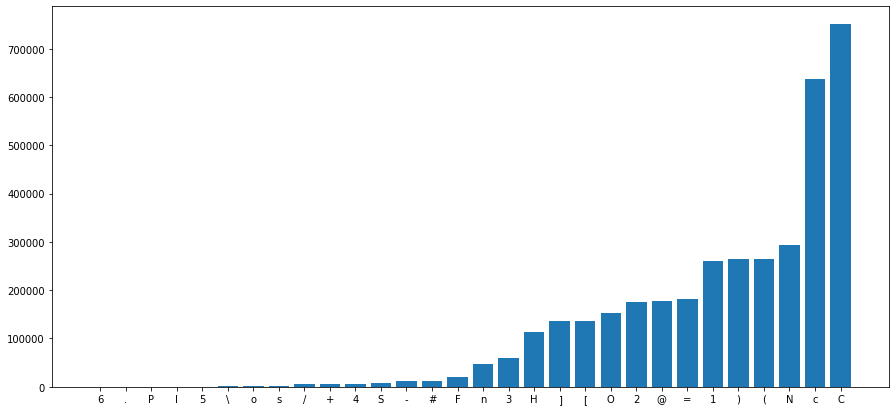

In [8]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.bar(freqs_df.index, freqs_df.frequency)
plt.show()

### SMILES vectorization
Now we can begin vectorization procedure.

In [9]:
def vectorize(smiles):
    one_hot = np.zeros((smiles.shape[0], embed, len(charset)), dtype=np.int8)
    for i, (smile,) in enumerate(smiles):
        one_hot[i, 0, char_to_int["!"]] = 1
        for j, c in enumerate(smile):
            one_hot[i, j + 1, char_to_int[c]] = 1
        one_hot[i, len(smile) + 1:, char_to_int["E"]] = 1
    return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

smiles    CC[C@@](C)(OC(C)=O)[C@H]1C(CN2CCOCC2)=NNN1CCc1...
Name: 59679, dtype: object


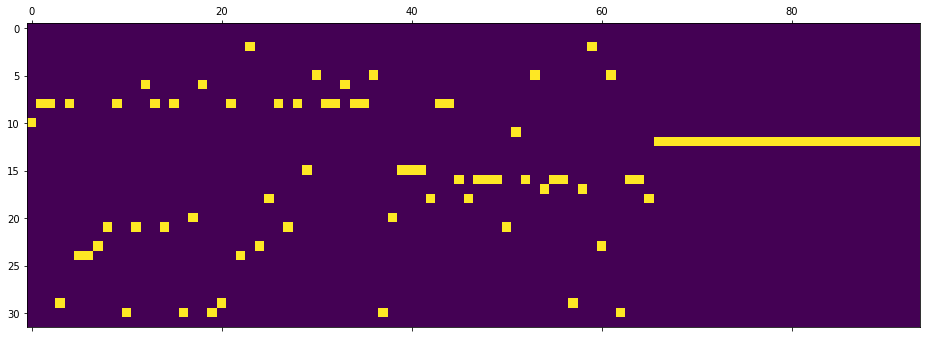

In [10]:
X_train, Y_train = vectorize(smiles_train.values)
X_test, Y_test = vectorize(smiles_test.values)
print(smiles_train.iloc[0])
plt.matshow(X_train[0].T)

## Model definition and training

In [28]:
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 128
lstm_dim = 128

unroll = False
encoder_inputs = Input(shape=input_shape, name='Smiles_input_1')

lstm_1 = LSTM(lstm_dim, return_state=True, return_sequences=True,
               unroll=unroll, name='Encoder_lstm')
lstm_2 = LSTM(lstm_dim, return_state=True,
               unroll=unroll, name='Encoder_lstm')

encoder_outputs, state_h, state_c = lstm_1(encoder_inputs)
encoder_outputs, state_h, state_c = lstm_2(encoder_inputs)

states = Concatenate(axis=-1, name='States_concat')([state_h, state_c])
neck = Dense(latent_dim, activation="relu", name='Encoder_neck')
neck_outputs = neck(states)

free_energy_inputs = Input(shape=(1,), name='Energy_input')
concatenate = Concatenate(axis=-1, name='Energy_concat')
energy_concat = concatenate([neck_outputs, free_energy_inputs])

decode_h = Dense(lstm_dim, name='State_h_decoder', activation="relu")
decode_c = Dense(lstm_dim, name='State_c_decoder', activation="relu")
state_h_decoded = decode_h(energy_concat)
state_c_decoded = decode_c(energy_concat)

batch_norm_h = BatchNormalization(name='State_h_BN')(state_h_decoded)
batch_norm_c = BatchNormalization(name='State_c_BN')(state_c_decoded)

encoder_states = [batch_norm_h, batch_norm_c]
decoder_inputs = Input(shape=input_shape, name='Smiles_input_2')


decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    name='Decoder_lstm'
                    )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(output_dim, activation='softmax', name='Decoder_output')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
state_c.shape

TensorShape([None, 64])

In [29]:
model = Model([encoder_inputs, decoder_inputs, free_energy_inputs], decoder_outputs, name='Lstm_autoencoder')
plot_model(model, to_file='model.png', show_layer_activations=True)
print(model.summary())

Model: "Lstm_autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Smiles_input_1 (InputLayer)    [(None, 94, 32)]     0           []                               
                                                                                                  
 Encoder_lstm (LSTM)            [(None, 128),        82432       ['Smiles_input_1[0][0]']         
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                                  
 States_concat (Concatenate)    (None, 256)          0           ['Encoder_lstm[0][1]',           
                                                                  'Encoder_lstm[0][

In [30]:
from keras.callbacks import History, ReduceLROnPlateau
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.000001, verbose=1, min_delta=1e-5)

opt = Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [31]:
model.fit([X_train, X_train, energy_train], Y_train,
                    epochs=50,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=([X_test, X_test, energy_test], Y_test))

Epoch 1/50
266/266 [==============================] - 11s 24ms/step - loss: 0.7755 - val_loss: 0.4783 - lr: 0.0050
Epoch 2/50
266/266 [==============================] - 6s 21ms/step - loss: 0.2897 - val_loss: 0.9444 - lr: 0.0050
Epoch 3/50
266/266 [==============================] - 6s 21ms/step - loss: 0.2410 - val_loss: 0.9506 - lr: 0.0050
Epoch 4/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1687 - val_loss: 0.6946 - lr: 0.0050
Epoch 5/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1467 - val_loss: 0.8569 - lr: 0.0050
Epoch 6/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1316 - val_loss: 0.6132 - lr: 0.0050
Epoch 7/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1171 - val_loss: 0.9572 - lr: 0.0050
Epoch 8/50
266/266 [==============================] - 6s 21ms/step - loss: 0.1071 - val_loss: 0.6243 - lr: 0.0050
Epoch 9/50
266/266 [==============================] - 6s 21ms/step - loss: 0.0968 - val

In [18]:
import pickle
with open("Blog_history.pickle", "wb") as f:
    pickle.dump(h.history, f)

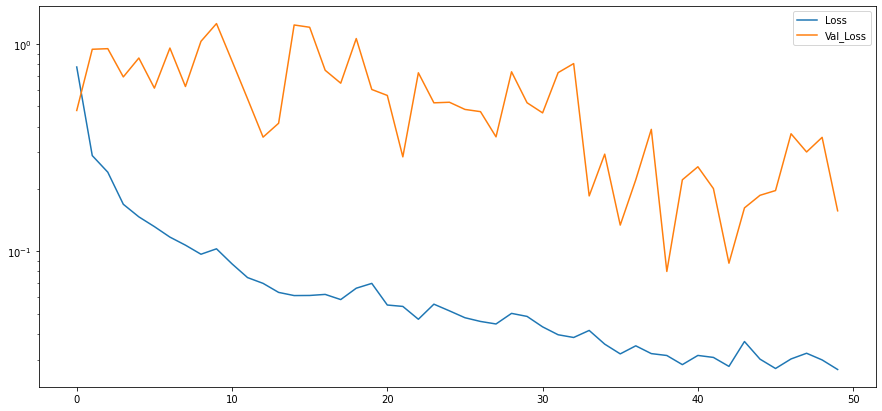

In [32]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

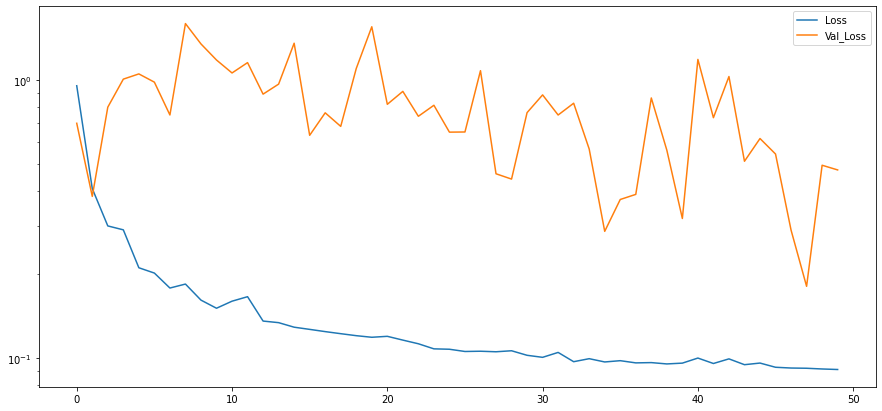

In [27]:
plt.plot(h.history["loss"], label="Loss")
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()

## Split autoencoder into 2 models

In [ ]:
smiles_to_latent_model = Model(encoder_inputs, neck_outputs)
smiles_to_latent_model.save("Blog_simple_smi2lat.h5")

In [ ]:
latent_input = Input(shape=(latent_dim,))
energy_input = Input(shape=(1,))

energy_concat_2 = concatenate([latent_input, energy_input])

state_h_decoded_2 = decode_h(energy_concat_2)
state_c_decoded_2 = decode_c(energy_concat_2)

latent_to_states_model = Model([latent_input, energy_input], 
                               [state_h_decoded_2, state_c_decoded_2])
latent_to_states_model.save("Blog_simple_lat2state.h5")
latent_to_states_model.summary()

2022-04-05 17:55:20.947 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_38 (InputLayer)          [(None, 64)]         0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Energy_concat (Concatenate)    (None, 65)           0           ['input_38[0][0]',               
                                                                  'input_39[0][0]']               
                                                                                                  
 State_h_decoder (Dense)        (None, 64)           4224        ['Energy_concat[1][0]']   

In [ ]:
inf_decoder_inputs = Input(batch_shape=(1, 1, input_shape[1]))

inf_decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True,
                    unroll=unroll,
                    stateful=True
                   )
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = Model(inf_decoder_inputs, inf_decoder_outputs)

In [ ]:
sample_model.layers[1].set_weights(model.layers[-2].get_weights())
sample_model.layers[2].set_weights(model.layers[-1].get_weights())
sample_model.save("Blog_simple_samplemodel.h5")

sample_model.summary()

2022-04-05 17:55:26.024 WARNING tensorflow: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(1, 1, 22)]              0         
                                                                 
 lstm_26 (LSTM)              (1, 1, 64)                22272     
                                                                 
 dense_40 (Dense)            (1, 1, 22)                1430      
                                                                 
Total params: 23,702
Trainable params: 23,702
Non-trainable params: 0
_________________________________________________________________


## New compounds generation

In [ ]:
x_latent = smilesmodel_to_latent_model.predict(X_test)
free_energy_value = -8
free_energy = np.array([free_energy_value])

In [ ]:
def latent_to_smiles(latent, free_energy):
    states = latent_to_states_model.predict([latent, free_energy])
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    # добавление стартового символа
    startidx = char_to_int["!"]
    samplevec = np.zeros((1, 1, len(charset)))
    samplevec[0,0,startidx] = 1
    smiles = ""
    # предсказание следующего символа
    for i in range(embed):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1, 1, len(charset)))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [ ]:
smiles = latent_to_smiles(x_latent[10:11], free_energy)
print(smiles)
print(smiles_test.iloc[10])

NN1C(=N)CCC1=N
NN1C(=N)CCC1=N


FC1CCO(CF)O1C
FC1CC(O1F)C#N
FC1C#NCC(F)=O1


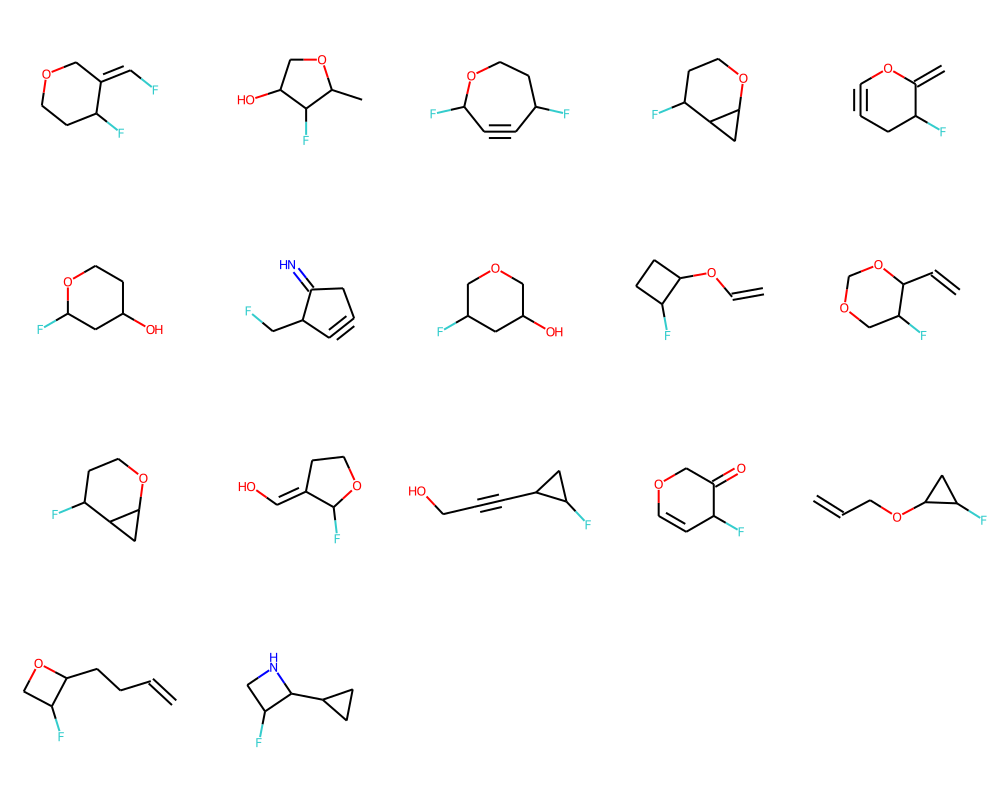

In [ ]:
# генерация соединения из latent space с добавлением шума
latent = x_latent[0:1]
scale = 0.30
mols = []
for i in range(20):
    latent_r = latent + scale*(np.random.randn(latent.shape[1]))
    smiles = latent_to_smiles(latent_r, free_energy)
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mols.append(mol)
    else:
        print(smiles)

Draw.MolsToGridImage(mols, molsPerRow=5)

## 3D molecule visualization

In [ ]:
import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem

def makeblock(smi):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    mblock = Chem.MolToMolBlock(mol)
    return mblock

def render_mol(xyz):
    xyzview = py3Dmol.view()
    xyzview.addModel(xyz,'mol')
    xyzview.setStyle({'stick':{}})
    xyzview.setBackgroundColor('white')
    xyzview.zoomTo()
    xyzview.show()


compound_smiles = smiles_train.iloc[0]
blk = makeblock(compound_smiles)
print(compound_smiles)
render_mol(blk)

COc1nncn1O


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

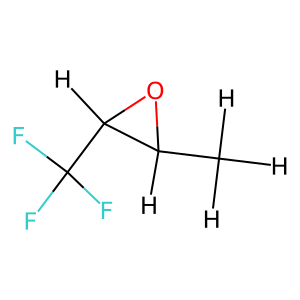

In [ ]:
mol = AllChem.MolFromSmiles(compound_smiles)
mol = Chem.AddHs(mol)
Draw.MolToImage(mol)